In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import spacy
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from bs4 import BeautifulSoup
import unicodedata
from textblob import TextBlob
import en_core_web_sm
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS

stopwords = set(STOPWORDS)

from sklearn.feature_extraction.text import CountVectorizer

In [2]:
df = pd.read_csv('twitter_sentiment.csv',encoding='unicode_escape',header=None, index_col=[0])
df = df[[2,3]].reset_index(drop=True)
df.columns = ['sentiment', 'text']
df.head()

,sentiment,text
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


In [3]:
print(df.shape)

(75685, 2)


In [4]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75685 entries, 0 to 75684
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  75685 non-null  object
 1   text       74999 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [5]:
df.isnull().sum()



sentiment      0
text         686
dtype: int64

In [6]:

df.dropna(inplace=True)



In [7]:
df.isnull().sum()

sentiment    0
text         0
dtype: int64

In [8]:
print(df.shape)
df = df[df['text'].apply(len)>5]
print(df.shape)

(74999, 2)
(72894, 2)


In [9]:
df[['text']]

,text
0,im getting on borderlands and i will murder yo...
1,I am coming to the borders and I will kill you...
2,im getting on borderlands and i will kill you ...
3,im coming on borderlands and i will murder you...
4,im getting on borderlands 2 and i will murder ...
...,...
75680,Bought a fraction of Microsoft today. Small wins.
75681,Johnson & Johnson to stop selling talc baby po...
75682,imran khan put in adiala jail
75683,imran khan gets bail from jail


In [10]:
df['sentiment'].value_counts()

sentiment
Negative      22023
Positive      20192
Neutral       17901
Irrelevant    12778
Name: count, dtype: int64

In [11]:
def _get_wordcounts(x):
	length = len(str(x).split())
	return length

def _get_charcounts(x):
	s = x.split()
	x = ''.join(s)
	return len(x)

def _get_avg_wordlength(x):
	count = _get_charcounts(x)/_get_wordcounts(x)
	return count

def _get_stopwords_counts(x):
	l = len([t for t in x.split() if t in stopwords])
	return l

def _get_hashtag_counts(x):
	l = len([t for t in x.split() if t.startswith('#')])
	return l

def _get_mentions_counts(x):
	l = len([t for t in x.split() if t.startswith('@')])
	return l

def _get_digit_counts(x):
	digits = re.findall(r'[0-9,.]+', x)
	return len(digits)

def _get_uppercase_counts(x):
	return len([t for t in x.split() if t.isupper()])

In [12]:


def _remove_urls(x):
    return re.sub(r'(http|https|ftp|ssh)://([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:/~+#-]*[\w@?^=%&/~+#-])?', '' , x)

def _remove_rt(x):
    return re.sub(r'\brt\b', '', x).strip()

def _remove_special_chars(x):
    x = re.sub(r'[^\w ]+', "", x)
    x = ' '.join(x.split())
    return x

def _remove_html_tags(x):
    return BeautifulSoup(x, 'lxml').get_text().strip()

def _remove_stopwords(x):
    return ' '.join([t for t in x.split() if t not in stopwords])	




In [13]:
def _get_basic_features(df):
    if type(df) == pd.core.frame.DataFrame:
        df['char_counts'] = df['text'].apply(lambda x: _get_charcounts(x))
        df['word_counts'] = df['text'].apply(lambda x: _get_wordcounts(x))
        df['avg_wordlength'] = df['text'].apply(lambda x: _get_avg_wordlength(x))
        df['stopwords_counts'] = df['text'].apply(lambda x: _get_stopwords_counts(x))
        df['hashtag_counts'] = df['text'].apply(lambda x: _get_hashtag_counts(x))
        df['mentions_counts'] = df['text'].apply(lambda x: _get_mentions_counts(x))
        df['digits_counts'] = df['text'].apply(lambda x: _get_digit_counts(x))
        df['uppercase_counts'] = df['text'].apply(lambda x: _get_uppercase_counts(x))
    else:
        print('ERROR: This function takes only Pandas DataFrame')
        
    return df

In [14]:
df.columns

Index(['sentiment', 'text'], dtype='object')

In [15]:
df=_get_basic_features(df)

In [16]:
df.columns

Index(['sentiment', 'text', 'char_counts', 'word_counts', 'avg_wordlength',
       'stopwords_counts', 'hashtag_counts', 'mentions_counts',
       'digits_counts', 'uppercase_counts'],
      dtype='object')

In [17]:
df.head()

,sentiment,text,char_counts,word_counts,avg_wordlength,stopwords_counts,hashtag_counts,mentions_counts,digits_counts,uppercase_counts
0,Positive,im getting on borderlands and i will murder yo...,43,11,3.909091,5,0,0,1,0
1,Positive,I am coming to the borders and I will kill you...,40,12,3.333333,5,0,0,1,2
2,Positive,im getting on borderlands and i will kill you ...,41,10,4.100000,4,0,0,1,0
3,Positive,im coming on borderlands and i will murder you...,42,10,4.200000,4,0,0,1,0
4,Positive,im getting on borderlands 2 and i will murder ...,46,12,3.833333,5,0,0,2,0


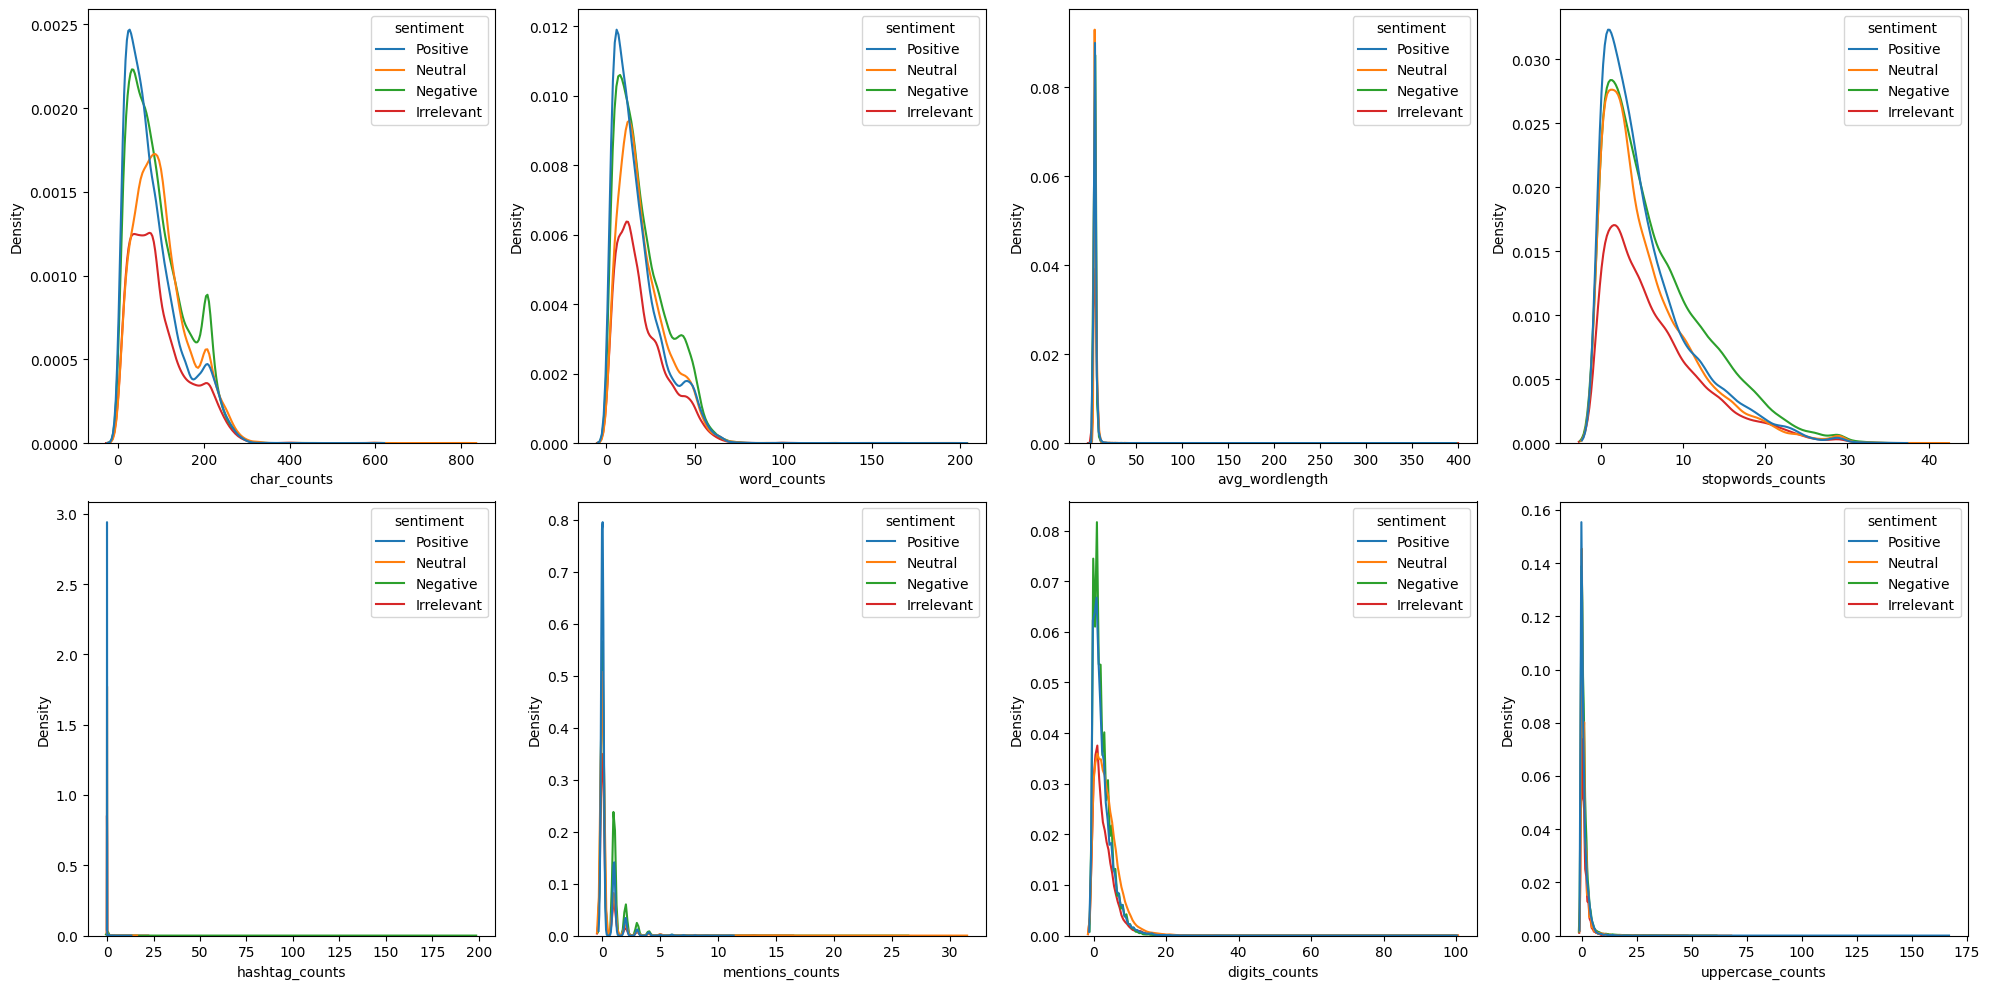

In [18]:
plt.figure(figsize=(20,10))

num_cols = df.select_dtypes(include='number').columns

for index,col in enumerate(num_cols):
    plt.subplot(2,4, index+1)
    sns.kdeplot(data=df, x=col, hue='sentiment', fill=False)

plt.tight_layout()
plt.show()

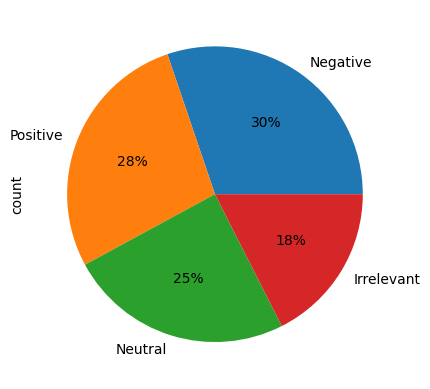

In [19]:
df['sentiment'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()

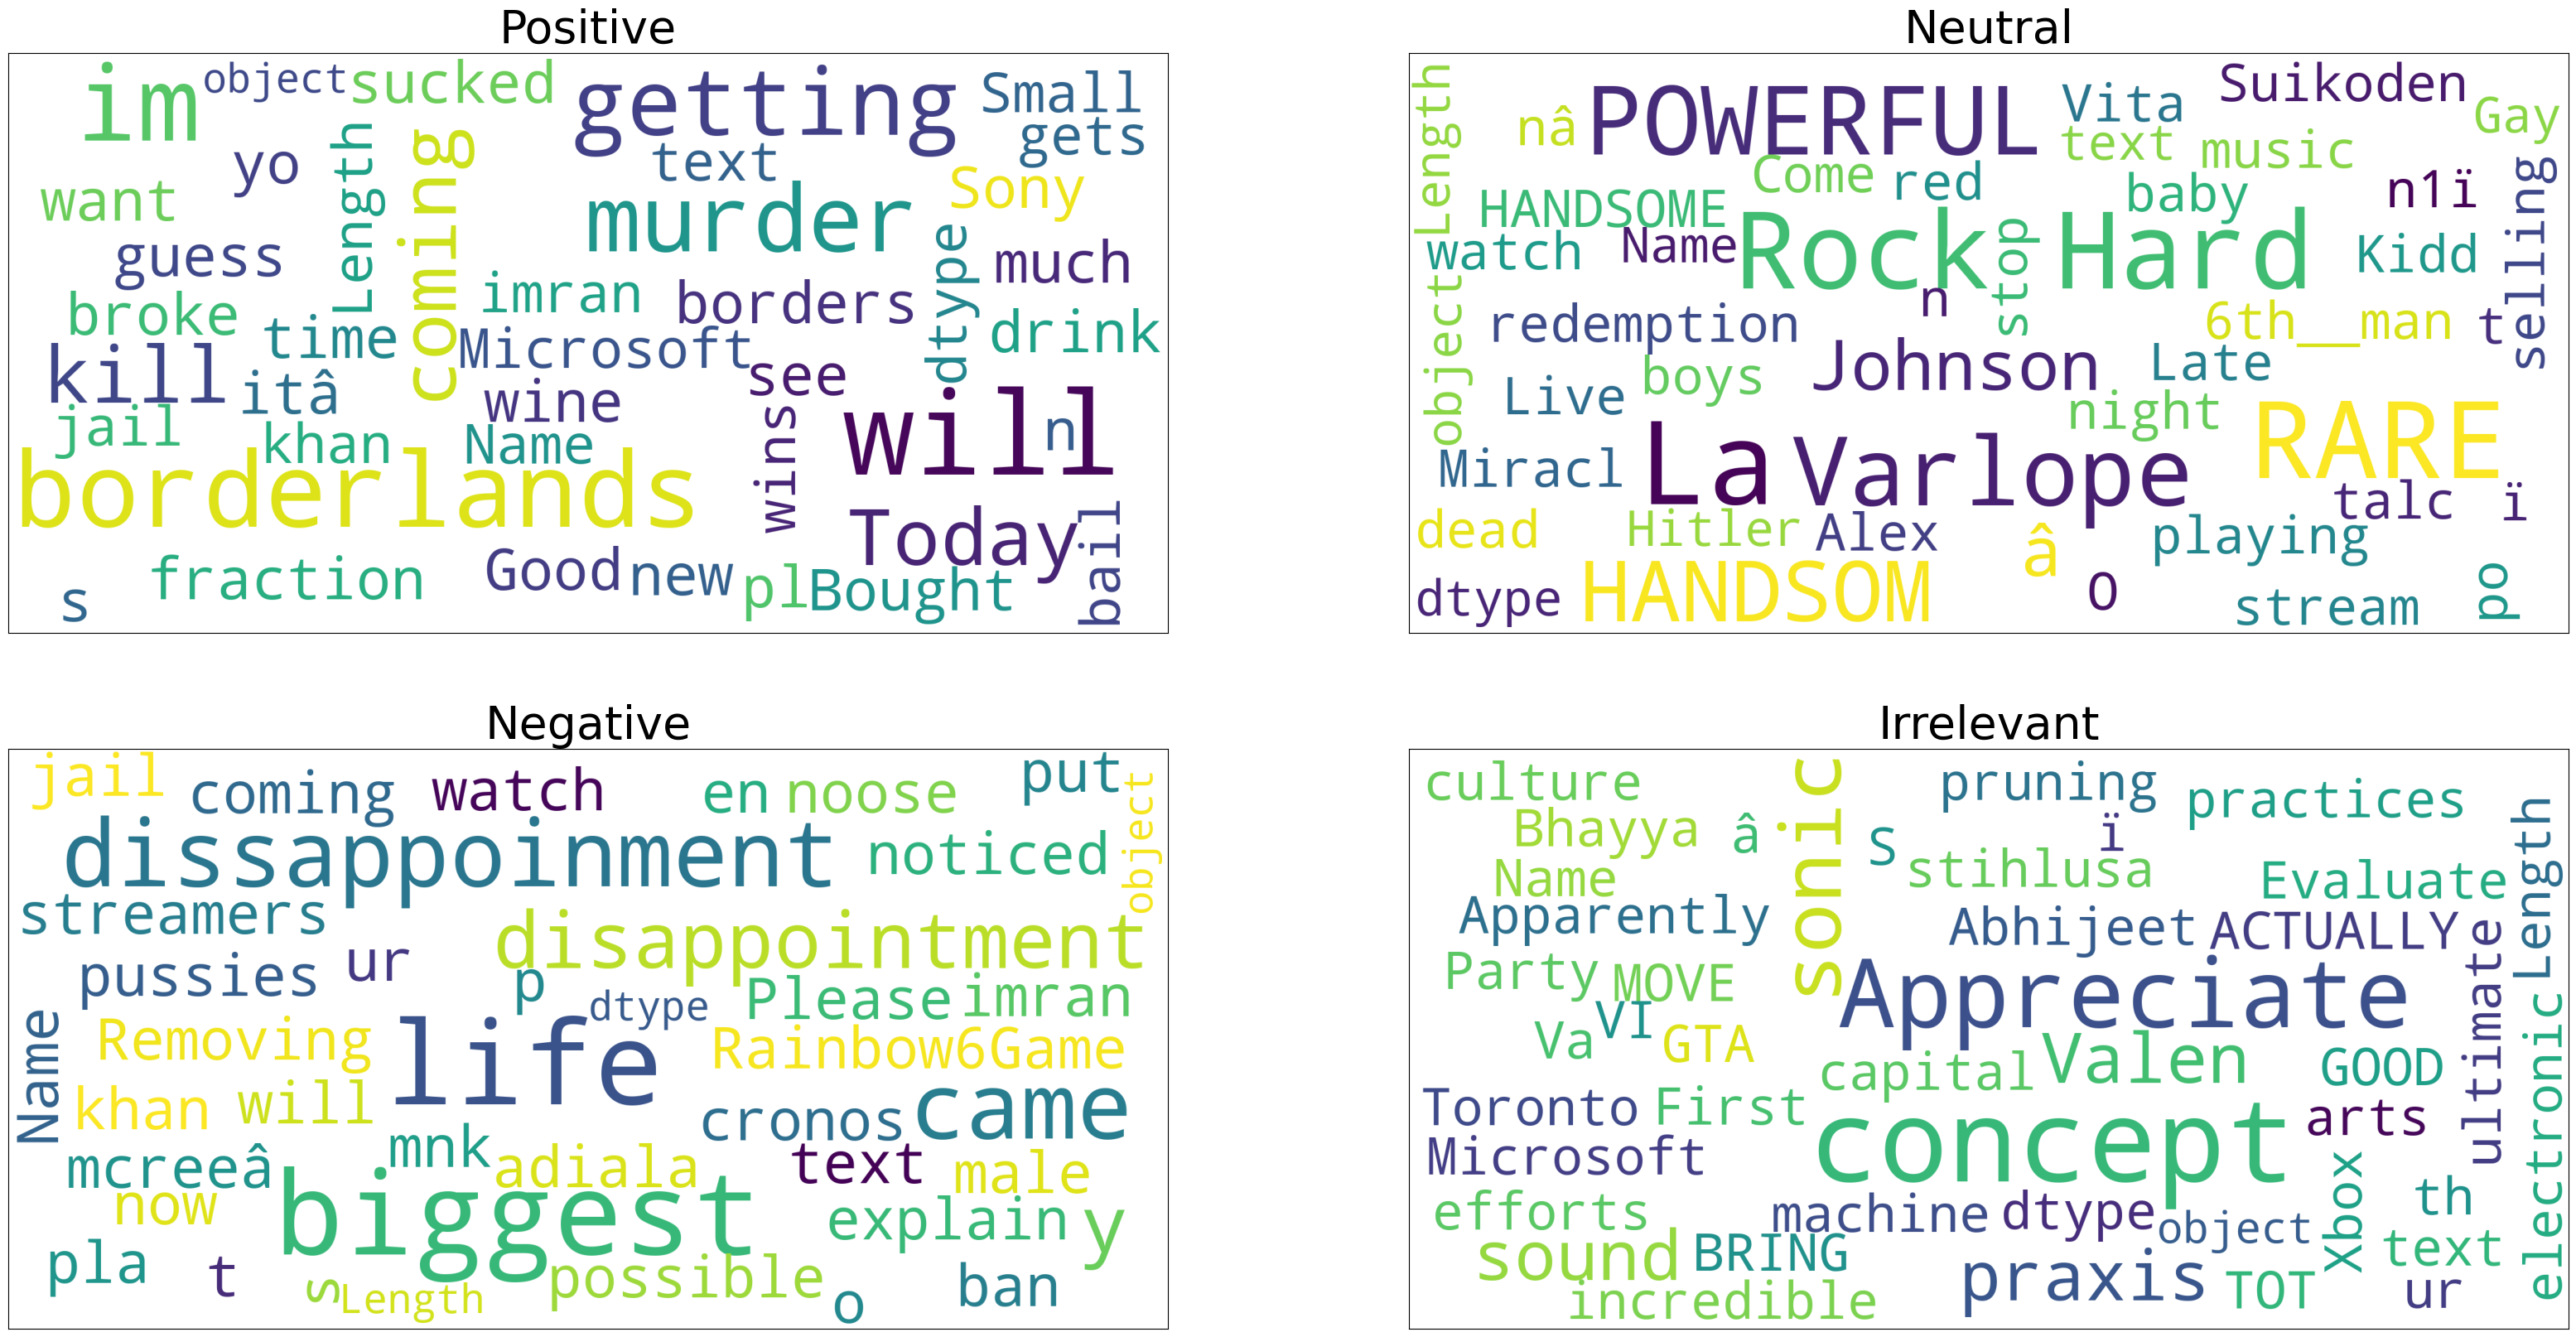

<Figure size 640x480 with 0 Axes>

In [20]:
plt.figure(figsize=(40,20))

for index, col in enumerate(df['sentiment'].unique()):
    plt.subplot(2,2, index+1)
    df1 = df[df['sentiment']==col]
    data = df1['text']
    wordcloud = WordCloud(background_color='white', stopwords=stopwords, max_words=500, max_font_size=40, scale=5).generate(str(data))
    plt.xticks([])
    plt.yticks([])
    plt.imshow(wordcloud)
    plt.title(col, fontsize=40)
    
plt.show()
plt.tight_layout()

In [21]:
df['text'] = df['text'].apply(lambda x: x.lower())
df['text'] = df['text'].apply(lambda x: _remove_urls(x))
#df['text'] = df['text'].apply(lambda x: _remove_html_tags(x))
df['text'] = df['text'].apply(lambda x: _remove_special_chars(x))
df['text'] = df['text'].apply(lambda x: _remove_rt(x))

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['sentiment'], test_size=0.2, random_state=42)

In [23]:
X_train.shape, X_test.shape

((58315,), (14579,))

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline



In [25]:
clf = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')), ('clf', RandomForestClassifier(n_estimators=100, n_jobs=-1))])
clf.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(stop_words='english')),
                ('clf', RandomForestClassifier(n_jobs=-1))])

In [26]:
from sklearn.metrics import classification_report

y_predict = clf.predict(X_test)
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

  Irrelevant       0.96      0.86      0.91      2526
    Negative       0.93      0.94      0.93      4418
     Neutral       0.92      0.91      0.91      3587
    Positive       0.88      0.95      0.91      4048

    accuracy                           0.92     14579
   macro avg       0.92      0.91      0.92     14579
weighted avg       0.92      0.92      0.92     14579



In [27]:
clf.predict(["imran khan put in adiala jail"])

array(['Negative'], dtype=object)

In [28]:
clf.predict(["Imran khan after 6 months gets bail from adiala jail"])

array(['Positive'], dtype=object)

In [29]:
clf.predict(["can i go to washroom"])

array(['Positive'], dtype=object)

In [30]:
clf.predict(['sir saeed is the best teacher in ubit'])

array(['Positive'], dtype=object)

In [31]:
clf.predict(["She took a breezy attitude to religious sentiment."])

array(['Negative'], dtype=object)

In [32]:
import pickle

pickle.dump(clf, open('twitter_sentiment.pkl', 'wb'))